In [389]:
import pandas as pd
import numpy as np
from scipy.stats import kruskal, mannwhitneyu
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import seaborn as sns
import scikit_posthocs as sp

def perform_mann_whitney(data, binary_col, exclude_cols):
    """
    Perform Mann-Whitney U test on continuous columns grouped by a binary column.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data.
    binary_col (str): The name of the binary column to group by.
    exclude_cols (list): List of column names to exclude from the analysis.

    Returns:
    pd.DataFrame: DataFrame containing the Mann-Whitney U test statistics and p-values.
    """
    # Identify continuous columns and exclude specified columns
    continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns
    continuous_columns = continuous_columns.drop(exclude_cols)

    # Perform Mann-Whitney U test for each continuous covariate
    mw_results = {}
    for col in continuous_columns:
        group1 = data[data[binary_col] == data[binary_col].unique()[0]][col].dropna()
        group2 = data[data[binary_col] == data[binary_col].unique()[1]][col].dropna()
        stat, p_value = mannwhitneyu(group1, group2)
        mw_results[col] = {'statistic': stat, 'p-value': p_value}

    # Convert results to a more readable format
    mw_df = pd.DataFrame(mw_results).T
    mw_df.columns = ['Mann-Whitney U Statistic', 'p-value']

    # Apply multiple test correction (Benjamini-Hochberg method)
    p_values = mw_df['p-value'].values
    _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
    mw_df['corrected p-value'] = corrected_p_values
    mw_df['-log(corrected p-value)'] = -np.log10(corrected_p_values)

    return mw_df

def plot_mann_whitney(mw_df, binary_col):
    """
    Plot the Mann-Whitney U test results.

    Parameters:
    mw_df (pd.DataFrame): DataFrame containing the Mann-Whitney U test statistics and p-values.
    binary_col (str): The name of the binary column to group by.

    Returns:
    None
    """
    # Sort the DataFrame so the highest -log(corrected p-value) is at the top
    sorted_df = mw_df.sort_values('-log(corrected p-value)', ascending=False)

    # Plot horizontal barplot
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_df.index, sorted_df['-log(corrected p-value)'], color='skyblue')
    plt.xlabel('-log(corrected p-value)')
    plt.ylabel('Continuous Covariates')
    plt.title(f'Mann-Whitney U Test Results for Continuous Covariates (Corrected) by {binary_col}')
    plt.axvline(x=-np.log10(0.05), color='r', linestyle='--', label='Significance Threshold (corrected p=0.05)')
    plt.legend()
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to show most significant at the top
    plt.show()

def perform_kruskal_wallis(data, categorical_col, exclude_cols):
    """
    Perform Kruskal-Wallis test on quantitative columns grouped by a categorical column.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data.
    categorical_col (str): The name of the categorical column to group by.
    exclude_cols (list): List of column names to exclude from the analysis.

    Returns:
    pd.DataFrame: DataFrame containing the Kruskal-Wallis statistics and p-values.
    """
    # Identify quantitative columns and exclude specified columns
    quantitative_columns = data.select_dtypes(include=['float64', 'int64']).columns
    quantitative_columns = quantitative_columns.drop(exclude_cols)

    # Perform Kruskal-Wallis test for each quantitative covariate
    kruskal_results = {}
    for col in quantitative_columns:
        groups = [data[data[categorical_col] == group][col].dropna() for group in data[categorical_col].unique()]
        stat, p_value = kruskal(*groups)
        kruskal_results[col] = {'statistic': stat, 'p_value': p_value}

    # Convert results to a more readable format
    kruskal_df = pd.DataFrame(kruskal_results).T
    kruskal_df.columns = ['Kruskal-Wallis Statistic', 'p-value']

    # Apply multiple test correction (Benjamini-Hochberg method)
    kruskal_df.dropna(subset=['p-value'], inplace=True)
    p_values = kruskal_df['p-value'].values
    _, corrected_p_values, _, _ = multipletests(p_values, method='fdr_bh')
    kruskal_df['corrected p-value'] = corrected_p_values
    kruskal_df['-log(corrected p-value)'] = -np.log10(corrected_p_values)

    return kruskal_df

def plot_kruskal_wallis(kruskal_df, categorical_col):
    """
    Plot the Kruskal-Wallis test results.

    Parameters:
    kruskal_df (pd.DataFrame): DataFrame containing the Kruskal-Wallis statistics and p-values.
    categorical_col (str): The name of the categorical column to group by.

    Returns:
    None
    """
    # Sort the DataFrame so the highest -log(corrected p-value) is at the top
    sorted_df = kruskal_df.sort_values('-log(corrected p-value)', ascending=False)

    # Plot horizontal barplot
    plt.figure(figsize=(10, 8))
    plt.barh(sorted_df.index, sorted_df['-log(corrected p-value)'], color='skyblue')
    plt.xlabel('-log(corrected p-value)')
    plt.ylabel('Quantitative Covariates')
    plt.title(f'Kruskal-Wallis Test Results for Quantitative Covariates (Corrected) by {categorical_col}')
    plt.axvline(x=-np.log10(0.05), color='r', linestyle='--', label='Significance Threshold (corrected p=0.05)')
    if sorted_df['-log(corrected p-value)'].max() < -np.log10(0.05):
        max_x = 5
    else:
        max_x = sorted_df['-log(corrected p-value)'].max() + 0.5
    plt.xlim(0, max_x)
    plt.legend(bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.gca().invert_yaxis()  # Invert y-axis to show most significant at the top
    plt.show()

def perform_dunn_posthoc(data, categorical_col, significant_covariates):
    """
    Perform Dunn's post-hoc test for pairwise comparisons on significant covariates.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data.
    categorical_col (str): The name of the categorical column to group by.
    significant_covariates (list): List of significant covariates to perform the post-hoc test on.

    Returns:
    dict: Dictionary containing the Dunn's post-hoc test results for each significant covariate.
    """
    dunn_results = {}
    for col in significant_covariates:
        dunn_results[col] = sp.posthoc_dunn(data, val_col=col, group_col=categorical_col, p_adjust='bonferroni')
    
    # Flatten the dunn_results into a dfs with group1, group2, p-value, then stack them
    dunn_results_df = pd.DataFrame()
    for col, result in dunn_results.items():
        result = result.stack().reset_index()
        result.columns = ['group1', 'group2', 'p-value']
        result['covariate'] = col
        dunn_results_df = dunn_results_df.append(result)

    # Remove duplicates where group1 and group2 are just reversed
    dunn_results_df = dunn_results_df[dunn_results_df['group1'] < dunn_results_df['group2']]
    dunn_results_df.reset_index(drop=True, inplace=True)
    
    return dunn_results_df

def run_analysis(metadata_df, categorical_col, exclude_cols):
    """
    Run the appropriate statistical tests based on the number of unique values in the categorical column.

    Parameters:
    metadata_df (pd.DataFrame): The input dataframe containing the metadata.
    categorical_col (str): The name of the categorical column to analyze.
    exclude_cols (list): List of column names to exclude from the analysis.

    Returns:
    None
    """
    n_unique = metadata_df[categorical_col].nunique()
    if n_unique == 2:
        print(f"{categorical_col} is binary. Running Mann-Whitney U test.")
        mw_df = perform_mann_whitney(metadata_df, categorical_col, exclude_cols)
        with sns.plotting_context('notebook', font_scale=1.2):
            plot_mann_whitney(mw_df, categorical_col)
        return mw_df
    elif n_unique > 2:
        print(f"{categorical_col} is categorical. Running Kruskal-Wallis test.")
        kruskal_df = perform_kruskal_wallis(metadata_df, categorical_col, exclude_cols)
        with sns.plotting_context('notebook', font_scale=1.2):
            plot_kruskal_wallis(kruskal_df, categorical_col)
        significant_covariates = kruskal_df[kruskal_df['corrected p-value'] < 0.05].index
        if len(significant_covariates) > 0:
            print(f"Running Dunn's post-hoc test on significant covariates: {', '.join(significant_covariates)}")
            dunn_kruskal_df = perform_dunn_posthoc(kruskal_df, categorical_col, significant_covariates)
        else:
            print("No significant covariates found. Skipping Dunn's post-hoc test.")
            dunn_kruskal_df = None
        return kruskal_df, dunn_kruskal_df
    else:
        print(f"{categorical_col} has only one unique value. Skipping analysis.")

# For the top results, plot boxplots
def plot_boxplots(
    metadata_df: pd.DataFrame,
    categorical_col: str,
    cols: list = None,
    results: pd.DataFrame = None,
    hue=None,
    sig=0.05,
    n_max=5,
    n_cols=3
) -> None:
    """
    Plot boxplots for the top significant covariates.

    Parameters:
    metadata_df (pd.DataFrame): The input dataframe containing the metadata.
    results (pd.DataFrame): DataFrame containing the statistical test results.
    categorical_col (str): The name of the categorical column to group by.

    Returns:
    None
    """
    if cols:
        top_results = cols
    else:
        assert results is not None, "Results must be provided if cols are not specified."
        results = results[results['corrected p-value'] < sig]
        top_results = results.sort_values('p-value').index[:n_max]
    if len(top_results) == 0:
        print(f"No significant covariates found with corrected p-value < {sig}.")
        return
    n_rows = int(np.ceil(n_max / n_cols))
    _, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    axes = np.ravel(axes)
    for i, covariate in enumerate(top_results):
        sns.boxplot(x=categorical_col, y=covariate, data=metadata_df, hue=hue, ax=axes[i])
        axes[i].set_title(covariate)
    for ax in axes[i + 1:]:
        ax.remove()
    plt.tight_layout()

# Load data

In [390]:
path_metadata = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/metadata/sample_annotation_metadata.tsv"
exclude_cols = ['year', 'sm3c_analysis_stage', 'sequencing_batch', 'timepoint', 'processed_multiome_location']

In [391]:
metadata_df = pd.read_csv(path_metadata, sep="\t", index_col=0)
metadata_df.head()

,sample_id,year,cell_line,differentiation_batch,timepoint,condition,sequencing_batch,multiome_analysis_stage,processed_multiome_location,sm3c_analysis_stage,...,joint:n_SC.delta,joint:n_SC.EC,joint:n_endocrine_progenitor,joint:n_pancreatic_progenitor,joint:n_proliferating_alpha,joint:n_other,joint:final_bcs,joint:n_clusters_wnn_leiden_1,joint:median_wnn_RNA_weight,joint:median_wnn_ATAC_weight
0,dm0b,2,A2,DM041,0,control,NaN,failed,NaN,NaN,...,0,2350,0,0,0,0,5549.0,12.0,0.468214,0.531786
1,dm25a,2,A2,DM041,24,control,NaN,annotated,NaN,NaN,...,47,2350,53,0,104,0,6662.0,15.0,0.604729,0.395271
2,dm35a,2,A2,DM041,48,control,NaN,annotated,NaN,NaN,...,47,1519,50,0,45,0,4298.0,14.0,0.616231,0.383769
3,dm45a,2,A2,DM041,72,control,NaN,annotated,NaN,NaN,...,79,1683,0,0,0,11,4357.0,18.0,0.579052,0.420948
4,mo1,1,H1,DM023,0,control,NaN,failed,NaN,NaN,...,43,860,47,0,21,0,2431.0,14.0,0.431133,0.568867


# Differentation batch

In [392]:
# Filter out DM023 for differentiation_batch
filtered_metadata_df = metadata_df[metadata_df['differentiation_batch'] != 'DM023']
filtered_metadata_df['differentiation_batch'].value_counts()

DM041    17
JE002    11
Name: differentiation_batch, dtype: int64

differentiation_batch is binary. Running Mann-Whitney U test.


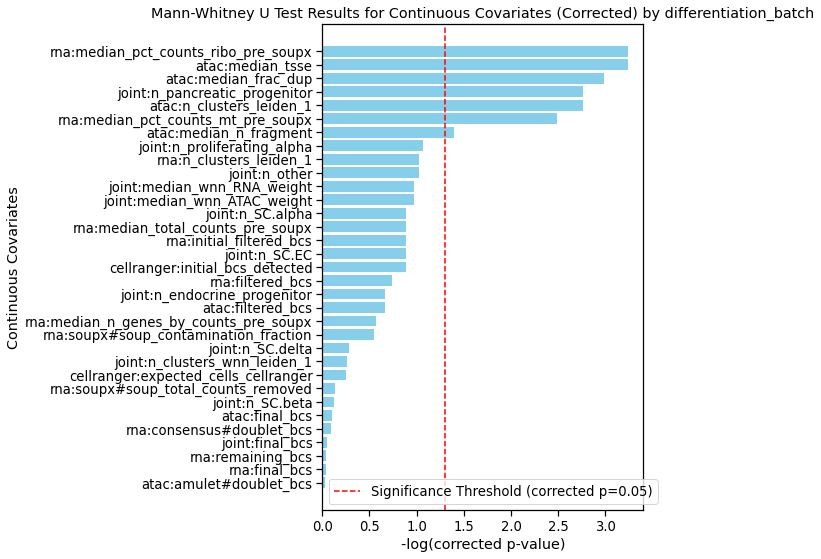

In [393]:
categorical_col = 'differentiation_batch'
results = run_analysis(filtered_metadata_df, categorical_col, exclude_cols)
if len(results) == 2:
    results, dunn_results = results

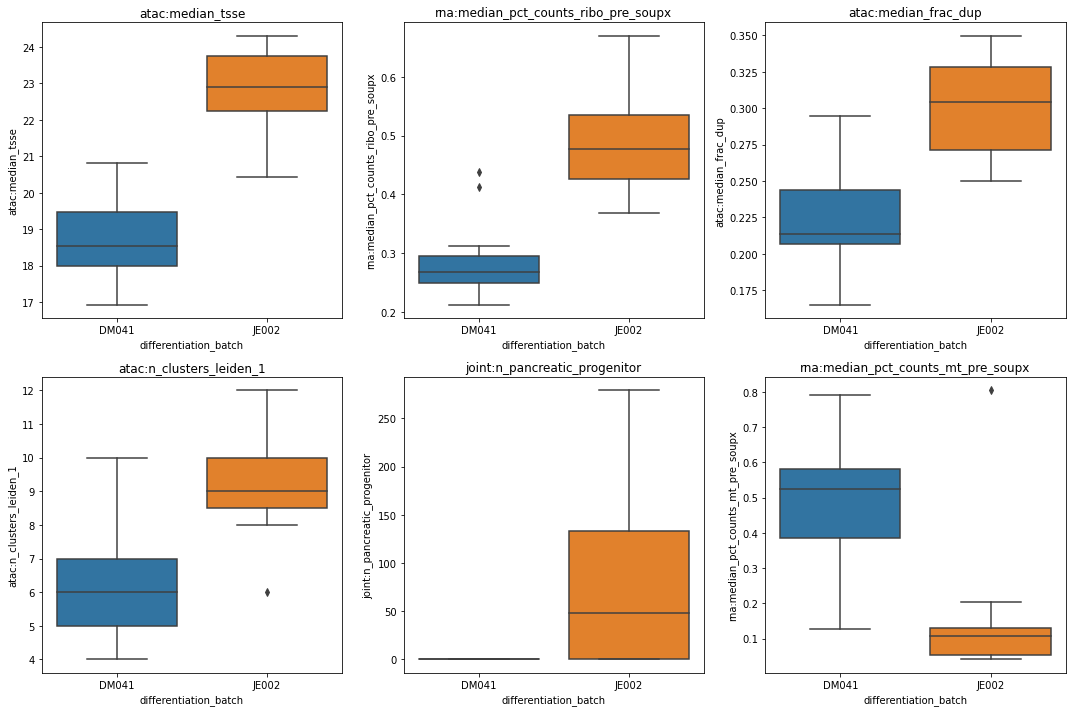

In [394]:
plot_boxplots(filtered_metadata_df, categorical_col, results=results, sig=0.1, n_max=6, n_cols=3)

# Condition

In [395]:
# Filter for differentiation_batch
filtered_metadata_df = metadata_df[metadata_df['differentiation_batch'] != 'DM023']
filtered_metadata_df['differentiation_batch'].value_counts()

DM041    17
JE002    11
Name: differentiation_batch, dtype: int64

In [396]:
# Filter for control and other conditions
condition = "3-cyt"
if condition != "all":
    filtered_metadata_df = filtered_metadata_df[filtered_metadata_df['condition'].isin(['control', condition])]
filtered_metadata_df['condition'].value_counts()

control    6
3-cyt      5
Name: condition, dtype: int64

condition is binary. Running Mann-Whitney U test.


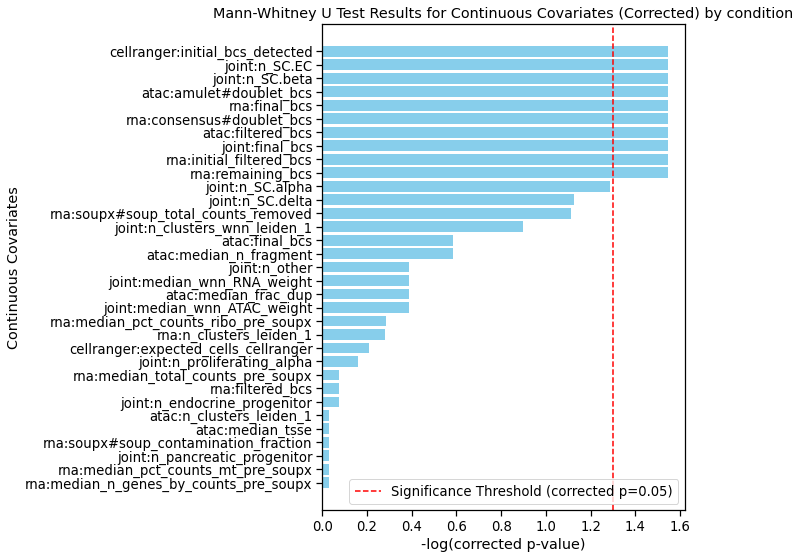

In [398]:
categorical_col = 'condition'
results = run_analysis(filtered_metadata_df, categorical_col, exclude_cols)
if len(results) == 2:
    results, dunn_results = results

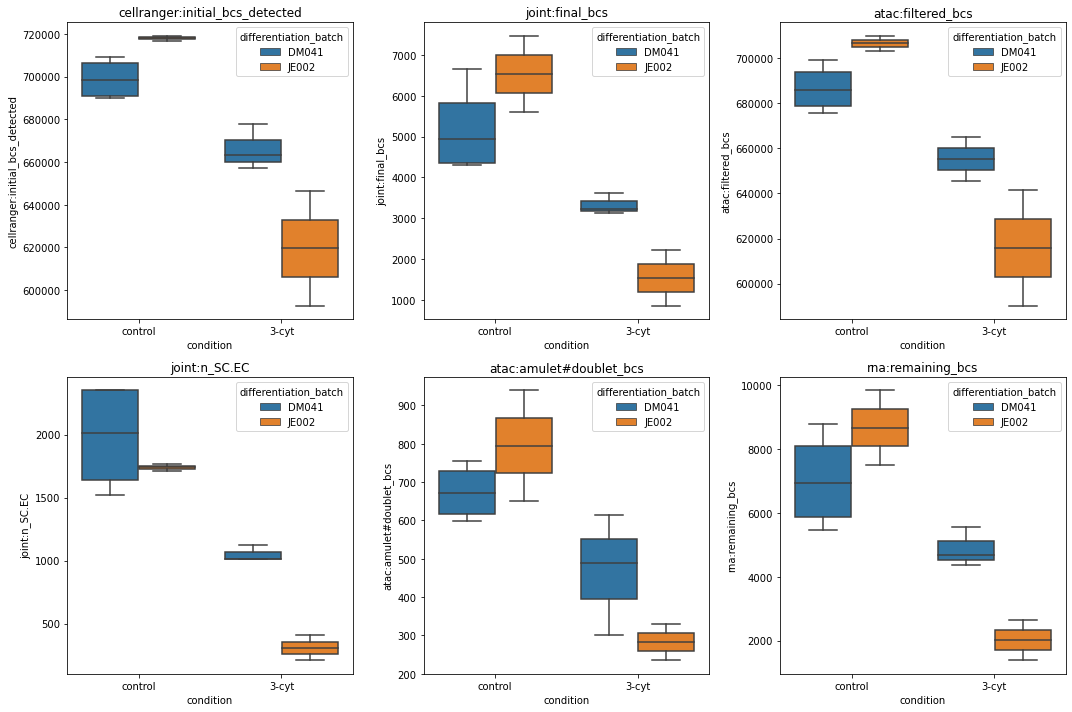

In [399]:
plot_boxplots(filtered_metadata_df, categorical_col, results=results, hue="differentiation_batch", sig=1, n_max=6, n_cols=3)

# Clustermap

## Sample

In [500]:
def plot_sample_correlation_clustermap(data, exclude_cols, metadata_cols=None, cmaps=None, annot=False, figsize=(12, 12), return_correlation_matrix=False):
    """
    Plot a clustermap of the correlation matrix for samples based on continuous covariates,
    with optional metadata annotations.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data.
    exclude_cols (list): List of column names to exclude from the analysis.
    metadata_cols (list): List of metadata column names for annotations (default is None).

    Returns:
    None
    """
    # Make a copy of the data
    data = data.copy()

    # Identify continuous columns and exclude specified columns
    continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns
    continuous_columns = continuous_columns.drop(exclude_cols)

    # Make sample_id the index
    data.set_index('sample_id', inplace=True)
    
    # Compute the correlation matrix for samples
    sample_correlation_matrix = data[continuous_columns].transpose().corr()

    # If cmap is not provided, use different qualitative cmaps for each metadata column
    if cmaps is None:
        cmaps = ['tab10', 'Set3', 'Dark2', 'tab20', 'tab20b', 'tab20c', 'Paired', 'Accent', 'Pastel1', 'Pastel2', 'Set1', 'Set2', 'Set3', 'tab10', 'tab20', 'tab20b', 'tab20c']
    
    # Prepare metadata annotations if provided
    row_colors = None
    if metadata_cols:
        unique_vals = {col: data[col].unique() for col in metadata_cols}
        color_dict = {}
        row_colors = []

        for i, col in enumerate(metadata_cols):
            unique_val_count = len(unique_vals[col])
            cmap = sns.color_palette(cmaps[i], n_colors=unique_val_count)
            color_dict[col] = {val: cmap[i] for i, val in enumerate(unique_vals[col])}
            row_colors.append(data[col].map(color_dict[col]))

        row_colors = pd.DataFrame(row_colors).T

    # Plot the clustermap
    plt.figure(figsize=figsize)
    sns.clustermap(sample_correlation_matrix, annot=annot, cmap='coolwarm', figsize=figsize, row_colors=row_colors, col_colors=row_colors)

    # Create a legend for the metadata outside the plot on the right
    if metadata_cols:
        for col in metadata_cols:
            for val in unique_vals[col]:
                plt.plot([], [], marker="o", ls="", mec=None, color=color_dict[col][val], label=f"{col}: {val}")
        plt.legend(bbox_to_anchor=(23, -1))

    plt.show()

    if return_correlation_matrix:
        return sample_correlation_matrix

In [507]:
# Keep only columns with atac in them
differentiation_batch = "all"
if differentiation_batch != "all":
    filtered_metadata_df = metadata_df[metadata_df['differentiation_batch'] != differentiation_batch]
else:
    filtered_metadata_df = metadata_df
condition = "all"
if condition != "all":
    filtered_metadata_df = filtered_metadata_df[filtered_metadata_df['condition'].isin(['control', condition])]
cols = ["sample_id", "condition", "differentiation_batch", "timepoint"] + filtered_metadata_df.columns[filtered_metadata_df.columns.str.contains("atac")].tolist()
#cols = filtered_metadata_df.columns
filtered_metadata_df = filtered_metadata_df[cols]
filtered_metadata_df

,sample_id,condition,differentiation_batch,timepoint,atac:amulet#doublet_bcs,atac:median_n_fragment,atac:median_frac_dup,atac:median_tsse,atac:n_clusters_leiden_1,atac:final_bcs,atac:filtered_bcs
0,dm0b,control,DM041,0,719,13190.5,0.248462,18.519094,7,9144,699107.0
1,dm25a,control,DM041,24,622,15856.5,0.255667,17.992202,6,9620,679864.0
2,dm35a,control,DM041,48,756,12477.5,0.200879,18.540498,6,14890,675500.0
3,dm45a,control,DM041,72,598,8367.0,0.294882,17.607897,7,13093,691915.0
4,mo1,control,DM023,0,288,26199.5,0.269310,20.407730,8,2734,664805.0
5,mo3,control,DM023,0,256,17678.0,0.272840,24.963716,8,2999,576249.0
6,mo14,control,DM023,6,203,20188.0,0.275899,24.005682,8,2541,582030.0
7,mo22,control,DM023,24,368,17741.5,0.268819,25.259472,7,5498,659055.0
8,mo29,control,DM023,48,156,20637.5,0.312151,25.405416,8,1610,547839.0
9,mo38,control,DM023,72,588,17885.0,0.265783,27.404828,9,7347,692260.0


<Figure size 1008x1296 with 0 Axes>

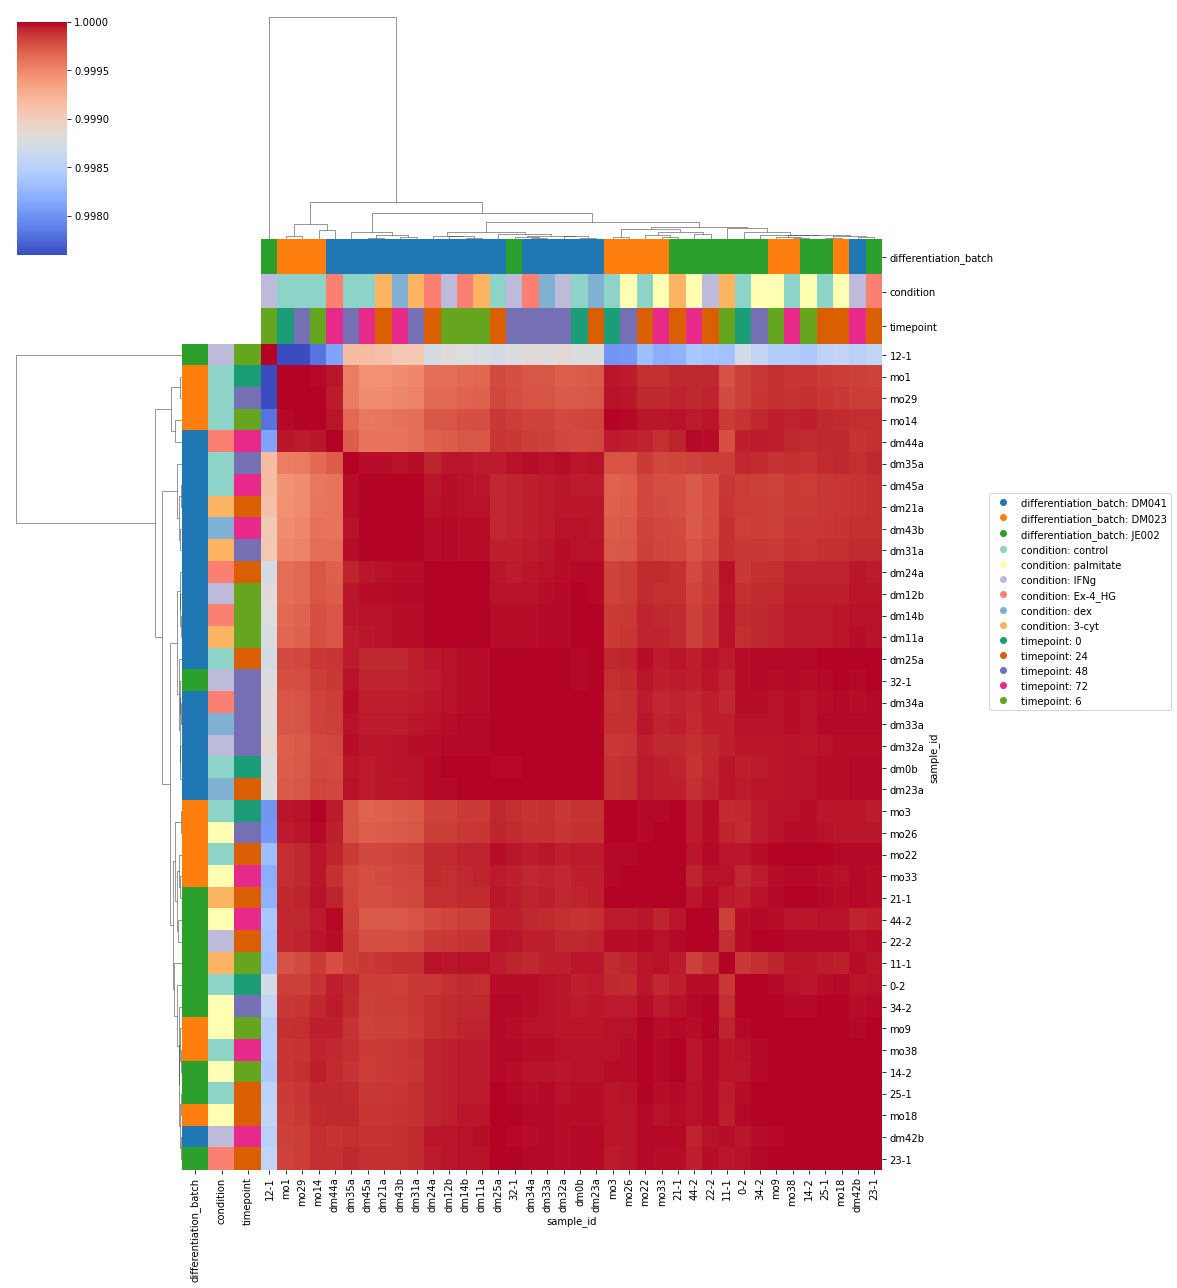

In [508]:
corr_matrix = plot_sample_correlation_clustermap(
    filtered_metadata_df, 
    exclude_cols=['timepoint'], 
    annot=False, 
    metadata_cols=['differentiation_batch', 'condition', 'timepoint'], 
    return_correlation_matrix=True, 
    figsize=(14, 18)
)

## Covariates

In [320]:
def plot_correlation_clustermap(data, exclude_cols, annot=False):
    """
    Plot a clustermap of the correlation matrix for continuous covariates.

    Parameters:
    data (pd.DataFrame): The input dataframe containing the data.
    exclude_cols (list): List of column names to exclude from the analysis.

    Returns:
    None
    """
    # Identify continuous columns and exclude specified columns
    continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns
    continuous_columns = continuous_columns.drop(exclude_cols)

    # Compute the correlation matrix
    correlation_matrix = data[continuous_columns].corr()

    # Plot the clustermap
    plt.figure(figsize=(12, 10))
    sns.clustermap(correlation_matrix, annot=annot, cmap='coolwarm', figsize=(12, 10))
    plt.title('Clustermap of Correlation Matrix for Continuous Covariates')
    plt.show()

<Figure size 864x720 with 0 Axes>

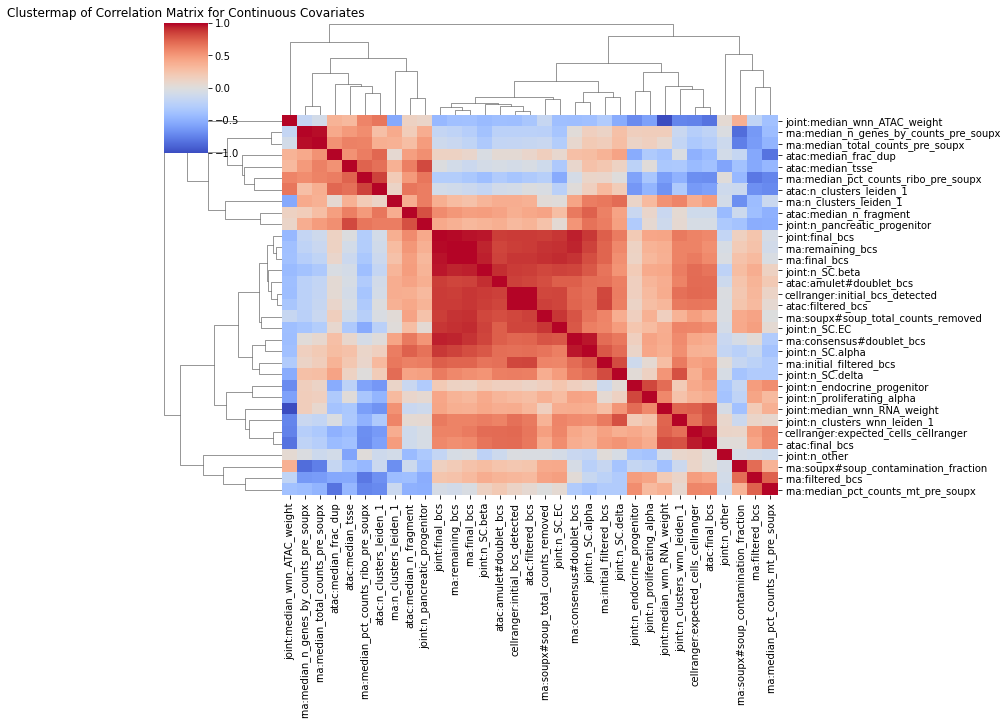

In [321]:
plot_correlation_clustermap(filtered_metadata_df, exclude_cols)

# DONE!

---